Step 1: Import required libraries

In [ ]:
#!pip install xformers

In [3]:
import pandas as pd
import numpy as np
import gc
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from textblob import TextBlob
import warnings
from tqdm import tqdm
from transformers import AutoTokenizer, pipeline
from concurrent.futures import ThreadPoolExecutor
warnings.filterwarnings("ignore")

Step 2: Download required NLTK data

In [6]:
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SURABHI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SURABHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SURABHI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Step 3: Load and preprocess data

In [9]:
print("Loading and preprocessing data...")

chunk_size = 50000
chunks = []  # Process data in chunks to handle large datasets


Loading and preprocessing data...


In [11]:
for chunk in pd.read_csv("E:\\job related docs\\Banao\\amazon\\Reviews.csv", chunksize=chunk_size):
    # Handle missing values
    chunk['ProfileName'].fillna('unknown', inplace=True)
    chunk['Summary'].fillna('', inplace=True)
    
    # Clean text
    chunk['cleaned_text'] = chunk['Text'].str.lower()
    chunk['cleaned_text'] = chunk['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    chunk['cleaned_text'] = chunk['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word)
                                                                          for word in word_tokenize(x)
                                                                          if word not in stop_words]))
    chunks.append(chunk)

df = pd.concat(chunks)
del chunks
gc.collect()

13

Step 4: Feature Engineering

In [13]:
print("Engineering features...")

Engineering features...


In [14]:
# Time-based features
df['timestamp'] = pd.to_datetime(df['Time'], unit='s')
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_holiday_season'] = df['month'].isin([11, 12]).astype(int)  # New feature for holiday season


In [15]:
# Interaction features
df['helpful_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['helpful_ratio'] = df['helpful_ratio'].fillna(0)

In [16]:
# Text-based Features
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['cleaned_text'].str.split().str.len()
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [17]:
# Text-based Features
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['cleaned_text'].str.split().str.len()
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [18]:
# Sentiment Features using Hugging Face Pipeline
#print("Loading Hugging Face sentiment analysis model...")
#sentiment_pipeline = pipeline('sentiment-analysis')

In [19]:
#model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [20]:
#from transformers import pipeline

#print("Loading Hugging Face sentiment analysis model...")
# Specify the model and revision explicitly
#model_name = "distilbert-base-uncased-finetuned-sst-2-english"
#revision = "af0f99b"

#sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, revision=revision)

# Example usage
#print("Model loaded successfully. Analyzing sentiment...")
#result = sentiment_pipeline("This is an amazing experience!")
#print(result)


In [21]:
#def generate_sentiment(text):
    #try:
        #sentiment = sentiment_pipeline(text[:512])[0]  # Process first 512 characters
       # return sentiment['score'], sentiment['label']
   # except Exception as e:
       # print(f"Error processing sentiment: {e}")
        #return None, None

In [22]:
print(f"Total number of rows: {len(df)}")


Total number of rows: 568454


In [23]:
#!pip install vaderSentiment


In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Example DataFrame (replace with your actual DataFrame)
# df = pd.DataFrame({'cleaned_text': ['I love this!', 'This is bad!', 'It is okay.']})

# Function to compute sentiment
def get_vader_sentiment(text):
    """
    Get sentiment score and label using VADER.
    Args:
        text (str): Input text.
    Returns:
        tuple: (label, compound score)
    """
    sentiment = analyzer.polarity_scores(text)
    label = 'POSITIVE' if sentiment['compound'] > 0 else 'NEGATIVE' if sentiment['compound'] < 0 else 'NEUTRAL'
    return label, sentiment['compound']

# Apply VADER sentiment analysis
df[['sentiment_label', 'sentiment_score']] = df['cleaned_text'].apply(
    lambda x: pd.Series(get_vader_sentiment(x))
)

# Display the updated DataFrame
print("Sentiment analysis completed!")
print(df.head())


Sentiment analysis completed!
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several o

In [25]:
#print(type(sentiment_results))
#print(sentiment_results)


In [26]:
# TF-IDF Features
print("Calculating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_features = tfidf.fit_transform(df['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'tfidf_{i}' for i in range(100)])


Calculating TF-IDF features...


In [27]:
# Merge TF-IDF features with the dataframe
df = pd.concat([df, tfidf_df], axis=1)


Step 5: Save Intermediate Results for Efficiency

In [29]:
print("Saving processed data with sentiment and TF-IDF features...")
df.to_csv('processed_data_sentiment_tfidf_features.csv', index=False)

Saving processed data with sentiment and TF-IDF features...


Step 6: Prepare Data for Modeling

In [97]:
print("Preparing data for modeling...")
target = 'Score'
features = ['text_length', 'word_count', 'avg_word_length', 'sentiment_score',
            'hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday_season', 'helpful_ratio'] + list(tfidf_df.columns)

X = df[features]
y = df[target]

Preparing data for modeling...


 Step 7: Train-Test Split

In [33]:
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Splitting data into training and testing sets...


Step 8: Feature Scaling

In [35]:
from sklearn.preprocessing import StandardScaler
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling features...


Step 9: Train Models

In [37]:
print("Training models...")
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LGBM': lgb.LGBMRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

results = {}
predictions = {}

Training models...


In [38]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    results[name] = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

Training GradientBoosting...
Training RandomForest...
Training XGBoost...
Training LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26788
[LightGBM] [Info] Number of data points in the train set: 454763, number of used features: 110
[LightGBM] [Info] Start training from score 4.181217
Training Ridge...
Training Lasso...


Step 10: Model Performance Comparison

In [40]:
print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")


Model Performance Comparison:

GradientBoosting:
RMSE: 1.0493
MAE: 0.7774
R2: 0.3533

RandomForest:
RMSE: 0.8406
MAE: 0.4971
R2: 0.5850

XGBoost:
RMSE: 0.9825
MAE: 0.7053
R2: 0.4331

LGBM:
RMSE: 1.0049
MAE: 0.7228
R2: 0.4069

Ridge:
RMSE: 1.0999
MAE: 0.8211
R2: 0.2895

Lasso:
RMSE: 1.3049
MAE: 1.0401
R2: -0.0001


Step 11: Visualizations

In [48]:
# List available styles
#print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [50]:
import matplotlib.pyplot as plt
print("Creating visualizations...")
# Use a valid Seaborn style
plt.style.use('seaborn-v0_8-darkgrid')

Creating visualizations...


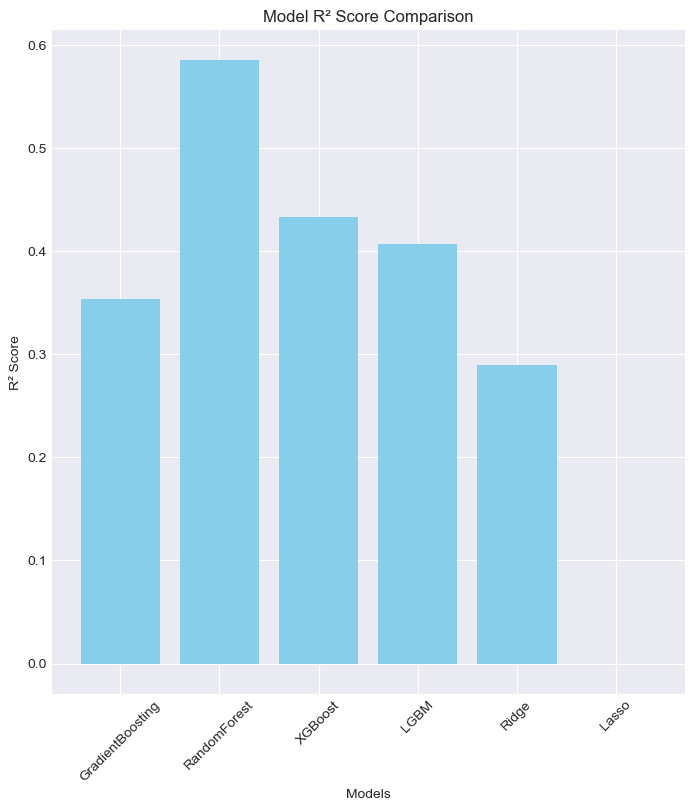

In [52]:
# R² Score Comparison
plt.figure(figsize=(20, 15))
plt.subplot(231)
model_names = list(results.keys())
r2_scores = [metrics['r2'] for metrics in results.values()]
plt.bar(model_names, r2_scores, color='skyblue')
plt.title('Model R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

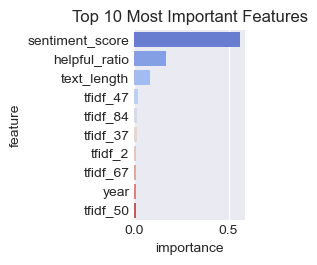

In [99]:


# Feature Importance for Gradient Boosting
plt.subplot(232)
gb_model = models['GradientBoosting']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='coolwarm')
plt.title('Top 10 Most Important Features')

plt.tight_layout()
plt.show()



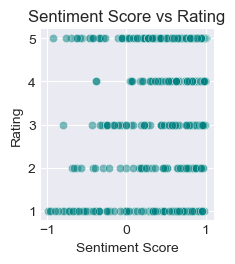

In [56]:

# Sentiment Score vs Rating
plt.subplot(233)
sns.scatterplot(data=df.sample(1000), x='sentiment_score', y='Score', alpha=0.5, color='teal')
plt.title('Sentiment Score vs Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

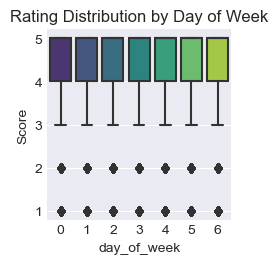

In [58]:
# Rating Distribution by Day of Week
plt.subplot(234)
sns.boxplot(data=df, x='day_of_week', y='Score', palette='viridis')
plt.title('Rating Distribution by Day of Week')

plt.tight_layout()
plt.show()

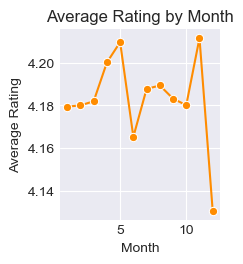

In [60]:
# Average Rating by Month
plt.subplot(235)
time_trends = df.groupby('month')['Score'].mean().reset_index()
sns.lineplot(data=time_trends, x='month', y='Score', marker='o', color='darkorange')
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')

plt.tight_layout()
plt.show()

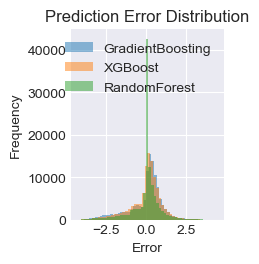

In [62]:
# Prediction Error Distribution
plt.subplot(236)
for name in ['GradientBoosting', 'XGBoost', 'RandomForest']:
    errors = y_test - predictions[name]
    plt.hist(errors, alpha=0.5, label=name, bins=50)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

 Step 12: Additional Visualizations

In [65]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

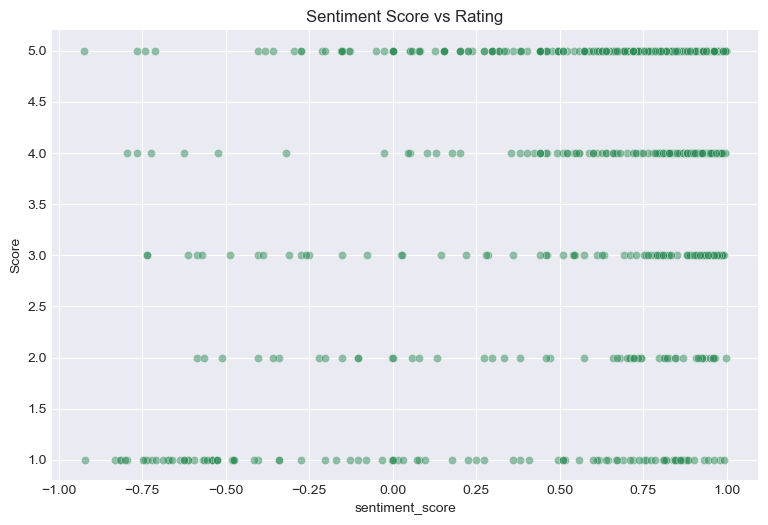

In [67]:
# Sentiment Score vs Rating (Alternative Scatter Plot)
plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.scatterplot(data=df.sample(1000), x='sentiment_score', y='Score', alpha=0.5, color='seagreen')
plt.title('Sentiment Score vs Rating')
plt.tight_layout()
plt.show()

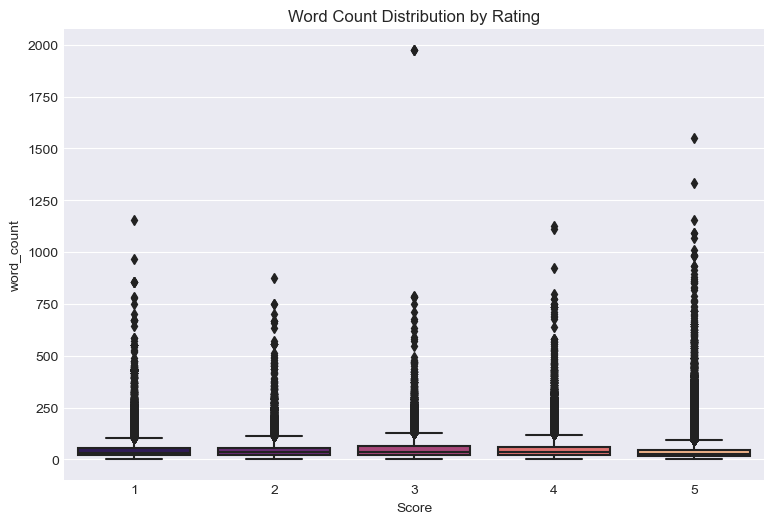

In [69]:
# Word Count Distribution by Rating
plt.figure(figsize=(15, 10))
plt.subplot(222)
sns.boxplot(data=df, x='Score', y='word_count', palette='magma')
plt.title('Word Count Distribution by Rating')
plt.tight_layout()
plt.show()

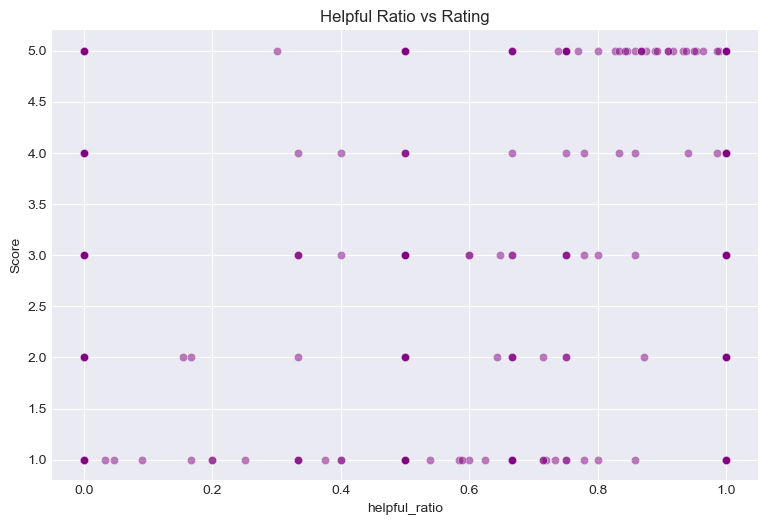

In [71]:
# Helpful Ratio vs Rating
plt.figure(figsize=(15, 10))
plt.subplot(223)
sns.scatterplot(data=df.sample(1000), x='helpful_ratio', y='Score', alpha=0.5, color='purple')
plt.title('Helpful Ratio vs Rating')
plt.tight_layout()
plt.show()

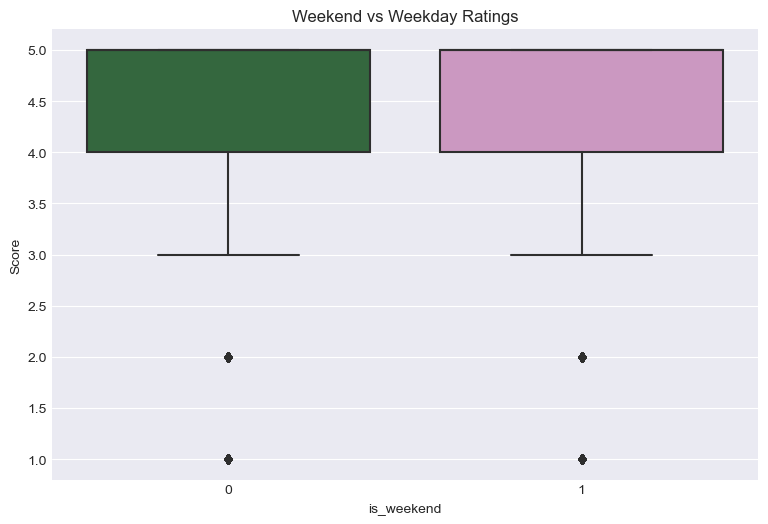

In [73]:
# Weekend vs Weekday Ratings
plt.figure(figsize=(15, 10))
plt.subplot(224)
sns.boxplot(data=df, x='is_weekend', y='Score', palette='cubehelix')
plt.title('Weekend vs Weekday Ratings')
plt.tight_layout()
plt.show()

Step 13: Save Results and Feature Importance

In [85]:
print("\nSaving results...")
results_df = pd.DataFrame(results).T
results_df.to_csv('model_performance.csv', index=True)


Saving results...


In [76]:
# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

Step 14: Clean Up Memory

In [78]:
print("Cleaning up memory...")
del X, y, X_train, X_test, y_train, y_test
gc.collect()

Cleaning up memory...


44507

In [79]:
print("Analysis complete!")

Analysis complete!



Prediction Pipeline

In [83]:
# Save the Best Model

In [87]:
import joblib

# Selecting the best model based on performance metrics
best_model_name = 'RandomForest'  # Chosen because it has the best RMSE, MAE, and R²
best_model = models[best_model_name]

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')

# Explanation of why the model was selected
print(f"The best model is {best_model_name} with the following metrics:")
print(f"RMSE: {results[best_model_name]['rmse']}")
print(f"MAE: {results[best_model_name]['mae']}")
print(f"R2: {results[best_model_name]['r2']}")

The best model is RandomForest with the following metrics:
RMSE: 0.8406429970096883
MAE: 0.4970789712683797
R2: 0.5849784298802296


In [ ]:
import joblib
best_model = models['GradientBoosting']  # or whichever model performed the best
joblib.dump(best_model, 'best_model.pkl')


In [ ]:
# Real-time Predictions

In [91]:


# Load the saved model
loaded_model = joblib.load('best_model.pkl')

# Example new data: Replace this with your real input values
# Ensure the new data matches the 111 features used in training
new_data = np.zeros((1, 111))  # Create an array with 111 features initialized to 0
new_data[0, :10] = [5, 100, 8, 0.5, 14, 2, 5, 2025, 0, 0.8]  # Set values for the first 10 features

# Make predictions
prediction = loaded_model.predict(new_data)
print("Predicted Rating:", prediction)


Predicted Rating: [1.91]
